In [29]:
import numpy as np
import pandas as pd
import cv2
from random import seed
from random import randint

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

import sklearn.decomposition as dec
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

import sklearn.metrics as mt


In [3]:
txt = pd.DataFrame(pd.read_csv('test/info.txt', sep='\t'))
print(txt.iloc[0])

filename            cctv052x2004080516x01638
date(yyyymmdd)                      20040805
timestamp                            16.0164
direction                              south
day/night                                day
weather                             overcast
start_frame                                2
number_of_frames                          53
class                                 medium
notes                                    NaN
Name: 0, dtype: object


**info.txt** is a file that containes additional information about our videos. Some of them will be used in all models, like *number_of frames* and *start_frame*. 

In [4]:
all_videos = []
for vd in txt.filename:
    cap = cv2.VideoCapture('video2/{}.avi'.format(vd))
    video = []
    idx = txt[txt.filename == vd].index[0]
    for i in range(txt.iloc[idx]['start_frame'], txt.iloc[idx]['number_of_frames']):
        ret, frame = cap.read()
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        video.append(np.array(gray))
    all_videos.append(np.array(video))


All videos are filmed from the same place. Some of them were filmed during special meteo conditions.
The videos have between 45 and 55 frames, each frame having 240x320 pixels. Here is as an example the first frame of the first video:

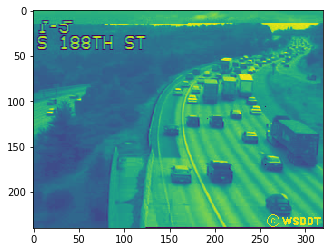

In [5]:
plt.imshow(all_videos[0][0])

As we can see, the left part of the frame is not a point of interest, so we can use a smaller version of it. Also in the bottom right corner of the image is some text we can exclude.

In [6]:
cut_videos = []
for video in all_videos:
    cut_videos.append(np.array([video[x][50:220, 150:] for x in range(0, video.shape[0])]))

cut_videos = np.array(cut_videos)

In [7]:
print(cut_videos[0].shape)

(51, 170, 170)


Now the frames have 170x170 pixels. <br>
Cut version of the same frame:

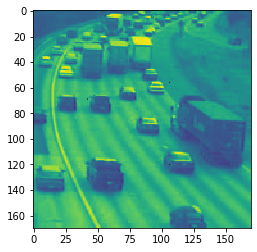

In [8]:
plt.imshow(cut_videos[0][0])

***Number of frames taken as input***

In [9]:
seed(1)

# cut_videos uses all frames
print('cut_videos containes {} videos. Shape of first video in cut_videos: '.format(len(cut_videos)), 
      np.array(cut_videos[0]).shape)

# cut_videos_1 uses one random frame from each video
cut_videos_1 = [cut_videos[x][randint(0, cut_videos[x].shape[0]-1)] for x in range(0, len(cut_videos))]
print('cut_videos_1 containes {} frames (one for each video). Shape of cut_videos_1: '.format(len(cut_videos_1)), 
      np.array(cut_videos_1).shape)

# cut_videos_half uses half of the frames from each video
cut_videos_half = []
for video in cut_videos:
    cut_videos_half.append([video[y] for y in range(0, video.shape[0]-1, 2)])
print('cut_videos_half containes {} videos. Shape of first video in cut_videos_half: '.format(len(cut_videos_half)), 
      np.array(cut_videos_half[0]).shape)

cut_videos containes 254 videos. Shape of first video in cut_videos:  (51, 170, 170)
cut_videos_1 containes 254 frames (one for each video). Shape of cut_videos_1:  (254, 170, 170)
cut_videos_half containes 254 videos. Shape of first video in cut_videos_half:  (25, 170, 170)



The models will take as input a number of frames from all videos.

**for cut_videos** 

In [23]:
videos_used = cut_videos

input_frames = []
for video in videos_used:
    for frame in video:
        input_frames.append(frame.flatten())

input_frames = np.array(input_frames)


**cut_videos_half**

In [10]:
videos_used = cut_videos_half

input_frames_half = []
for video in videos_used:
    for frame in video:
        input_frames_half.append(frame.flatten())

input_frames_half = np.array(input_frames_half)


**for cut_videos_1**

In [ ]:
videos_used = cut_videos_1

input_frames_1 = []
for video in videos_used:
    input_frames_1.append(video.flatten())

input_frames_1 = np.array(input_frames_1)


In [ ]:
print('input_frames has {} frames, each frame {} features.'.format(input_frames.shape[0], input_frames.shape[1]))
print('input_frames_1 has {} frames, each frame {} features.'.format(input_frames_1.shape[0], input_frames_1.shape[1]))
print('input_frames_half has {} frames, each frame {} features.'.format(input_frames_half.shape[0], input_frames_half.shape[1]))

**Standardize frames.**

In [24]:
# for input_frames
scaled = []
for data in input_frames:
    scaled.append(preprocessing.scale(data))


In [ ]:
# for input_frames_1
scaled_1 = []
for data in input_frames_1:
    scaled_1.append(preprocessing.scale(data))


In [11]:
# for input_frames_half
scaled_half = []
for data in input_frames_half:
    scaled_half.append(preprocessing.scale(data))


**True labels:**

In [12]:
true_labels = txt['class'].replace(to_replace=['light', 'medium', 'heavy'], value=[0, 1, 2])


**Define types of PCA used**

In [13]:
pca_2000 = dec.PCA(n_components=2000, random_state=0)
pca_1000 = dec.PCA(n_components=1000, random_state=0)
pca_100 = dec.PCA(n_components=100, random_state=0)
pca_50 = dec.PCA(n_components=50, random_state=0)
pca_25 = dec.PCA(n_components=25, random_state=0)

pca_05 = dec.PCA(n_components=0.5, svd_solver='full', random_state=0)
pca_07 = dec.PCA(n_components=0.7, svd_solver='full', random_state=0)
pca_08 = dec.PCA(n_components=0.8, svd_solver='full', random_state=0)


**fit_transform scaled input data**

In [ ]:
pca_2000_result = pca_2000.fit_transform(scaled)
# pca_1000_result = pca_1000.fit_transform(scaled_half)
# pca_100_result = pca_100.fit_transform(scaled_half)
# pca_50_result = pca_50.fit_transform(scaled_half)
# pca_25_result = pca_25.fit_transform(scaled_half)

pca_05_result = pca_05.fit_transform(scaled)
pca_07_result = pca_07.fit_transform(scaled)
pca_08_result = pca_08.fit_transform(scaled)

**Define types of AgglomerativeClustering**

In [15]:
agg_2000 = AgglomerativeClustering(n_clusters=3).fit_predict(pca_2000_result)
# agg_1000 = AgglomerativeClustering(n_clusters=3).fit_predict(pca_1000_result)
# agg_100 = AgglomerativeClustering(n_clusters=3).fit_predict(pca_100_result)
# agg_50 = AgglomerativeClustering(n_clusters=3).fit_predict(pca_50_result)
# agg_25 = AgglomerativeClustering(n_clusters=3).fit_predict(pca_25_result)

agg_05 = AgglomerativeClustering(n_clusters=3).fit_predict(pca_05_result)
agg_07 = AgglomerativeClustering(n_clusters=3).fit_predict(pca_07_result)
agg_08 = AgglomerativeClustering(n_clusters=3).fit_predict(pca_08_result)


**Define types of DBSCAN**

In [16]:
dbscan_2000 = DBSCAN(eps=70).fit_predict(pca_2000_result)
# dbscan_1000 = DBSCAN(eps=70).fit_predict(pca_1000_result)
# dbscan_100 = DBSCAN(eps=70, min_samples=3).fit_predict(pca_100_result)
# dbscan_50 = DBSCAN(eps=70).fit_predict(pca_50_result)
# dbscan_25 = DBSCAN(eps=70, min_samples=2).fit_predict(pca_25_result)

dbscan_05 = DBSCAN(eps=70, min_samples=2).fit_predict(pca_05_result)
dbscan_07 = DBSCAN(eps=70).fit_predict(pca_07_result)
dbscan_08 = DBSCAN(eps=70).fit_predict(pca_08_result)


In [17]:

# models_agg = {'agg_100': agg_100, 'agg_50': agg_50, 'agg_25': agg_25, 'agg_05': agg_05, 'agg_08': agg_08, 
#               'agg_07': agg_07, 'agg_1000': agg_1000, 'agg_2000': agg_2000}
# models_dbscan = {'dbscan_05': dbscan_05, 'dbscan_08': dbscan_08, 'dbscan_07': dbscan_07, 
#             'dbscan_25': dbscan_25, 'dbscan_50': dbscan_50, 'dbscan_100': dbscan_100, 
#                  'dbscan_1000': dbscan_1000, 'dbscan_2000': dbscan_2000}

models_agg = {'agg_05': agg_05, 'agg_08': agg_08, 'agg_07': agg_07, 'agg_2000': agg_2000}
models_dbscan = {'dbscan_05': dbscan_05, 'dbscan_08': dbscan_08, 'dbscan_07': dbscan_07, 'dbscan_2000': dbscan_2000}

**Evaluate DBSCAN**

In [21]:
# frame_labels= []
for model in models_dbscan:
    idx = 0
    classes = []
    frame_labels = pd.Series(models_dbscan[model]).replace(-1, max(set(models_dbscan[model]))+1)
    for video in cut_videos_half:
        classes.append(np.bincount(frame_labels[idx:idx + len(video)]).argmax())
        idx += len(video)
    print('Adj rand score for {} on input_frames_half: '.format(model), 
          mt.adjusted_rand_score(true_labels, classes))

Adj rand score for dbscan_05 on input_frames_half:  0.48479494652099625
Adj rand score for dbscan_08 on input_frames_half:  -0.08529585119473007
Adj rand score for dbscan_07 on input_frames_half:  -0.024369165341347667
Adj rand score for dbscan_2000 on input_frames_half:  -0.059195417400215396


**Evaluate AggomerativeClustering**

In [22]:
for model in models_agg:
    idx = 0
    classes = []
    frame_labels = models_agg[model]
    for video in cut_videos_half:
        classes.append(np.bincount(frame_labels[idx:idx + len(video)]).argmax())
        idx += len(video)
    print('Adj rand score for {} on input_frames_half: '.format(model), 
          mt.adjusted_rand_score(true_labels, classes))
    

Adj rand score for agg_05 on input_frames_half:  0.3054026809137578
Adj rand score for agg_08 on input_frames_half:  0.28842252392433576
Adj rand score for agg_07 on input_frames_half:  0.5606841957746606
Adj rand score for agg_2000 on input_frames_half:  0.5606841957746606


In [2]:
# list(true_labels)

In [63]:
best_data = pca_2000_result

grid = []

make_scorer(adjusted_rand_score)


In [86]:

parameters_agg = {'affinity':['euclidean', 'l1', 'l2'], 
                  'linkage': ['ward', 'complete', 'average', 'single']}

agg = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward').fit_predict(best_data)

# print(agg.shape)
idx=0
classes = []
for video in cut_videos_half:
    classes.append(np.bincount(agg[idx:idx + len(video)]).argmax())
    idx += len(video)

# print(classes)
grid.append(mt.adjusted_rand_score(true_labels, classes))
print('Adj rand score for on input_frames_half: ', 
          mt.adjusted_rand_score(true_labels, classes))

Adj rand score for on input_frames_half:  0.5606841957746606


In [87]:
print(grid)

[0.0, 0.0, 0.0, 0.01869452955584517, 0.0, 0.01869452955584517, 0.0, 0.0, 0.009459847886024095, 0.5606841957746606]


In [1]:
print('paper results for k-means: 0.585 0.624 0.494')

paper results for k-means: 0.585 0.624 0.494
